# Hedera Staking Simulation Visualization

This notebook demonstrates various visualizations of the Hedera staking simulation results.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Dict, List, Tuple
import pandas as pd

from staking.accounts import Treasury, StakingRewardsPool, NodeRewardsPool
from staking.managers import RewardsEngine, Nodes, Stakers, StakingSystem, calculate_transaction_fees

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [87]:
@dataclass
class Snapshot:
    day: int
    fees: float
    rs: float
    rn: float
    treasury_balance: float
    staking_pool_balance: float
    node_pool_balance: float | None
    total_staker_balance: float
    total_node_balance: float
    eligible_nodes: int
    staker_rewards: Dict[int, float]
    node_rewards: Dict[int, float]


def sum_balances(balance_map: Dict[int, float]) -> float:
    return float(sum(balance_map.values()))


def run_simulation(
    num_stakers: int = 500,
    num_nodes: int = 20,
    days: int = 20,
    seed: int = 123
) -> Tuple[List[Snapshot], StakingSystem]:
    """Run the simulation and collect snapshots."""
    rng = np.random.default_rng(seed)

    # Create system accounts
    treasury = Treasury(initial_balance=0.0)
    staking_pool = StakingRewardsPool(initial_balance=250.0)
    node_pool = NodeRewardsPool(initial_balance=100.0)

    # Create stakers and nodes managers
    stakers = Stakers(
        num_stakers=num_stakers,
        num_nodes=num_nodes,
        pareto_shape=2,  # heavier tail -> more whales
        p_switch=0.03,  # small switching probability (sticky)
        rng=rng,
    )

    nodes = Nodes(
        num_stakers=num_stakers,
        num_nodes=num_nodes,
        num_hbars=num_stakers * 10,  # *10 to scale for min/max stake caps
        node_id_offset=10000,
        pareto_shape=2,
        rng=rng,
    )

    # Rewards + fees engine
    engine = RewardsEngine(
        treasury=treasury,
        staking_pool=staking_pool,
        node_pool=node_pool,
        share_treasury=0.80,  # fee share to 0.0.98
        share_staking_pool=0.10,  # fee share to 0.0.800
        share_node_pool=0.10,  # fee share to 0.0.801
        beta=0.50,  # split between node-vs-staker rewards
        epsilon=0.05,
    )

    # Reward schedule parameters
    reward_params = dict(
        param_reward_a=0.01,
        param_reward_b=0.01,
        param_reward_c=5.0,
        param_reward_m=10.0,
    )

    system = StakingSystem(
        stakers=stakers,
        nodes=nodes,
        engine=engine,
        staking_pool=staking_pool,
        node_pool=node_pool,
        reward_params=reward_params,
    )

    # Track history
    history: List[Snapshot] = []
    
    # Explicit time series for balance tracking (balances, not deltas)
    treasury_balance_ts: List[float] = []
    staking_pool_balance_ts: List[float] = []
    node_pool_balance_ts: List[float] = []

    for day in range(days):
        # Pre-step
        treasury_before = treasury.balance
        staking_pool_before = staking_pool.balance
        node_pool_before = node_pool.balance
        total_staker_before = sum_balances(stakers.balance_stakers_account)
        total_node_before = sum_balances(nodes.balance_nodes_account)
        
        # Calculate actual transaction fees at current time (before step_day increments it)
        actual_fees = calculate_transaction_fees(t=engine.time)

        # One day step
        system.step_day()

        # Post-step stats
        
        # Calculate net flow: fees coming in minus rewards paid out
        treasury_delta = treasury.balance - treasury_before
        staking_pool_delta = staking_pool.balance - staking_pool_before
        node_pool_delta = node_pool.balance - node_pool_before
        net_flow = treasury_delta + staking_pool_delta + node_pool_delta

        total_staker_after = sum_balances(stakers.balance_stakers_account)
        total_node_after = sum_balances(nodes.balance_nodes_account)

        # Track balance time series (actual balances, not deltas)
        treasury_balance_ts.append(treasury.balance)
        staking_pool_balance_ts.append(staking_pool.balance)
        node_pool_balance_ts.append(node_pool.balance)

        eligible_count = len(nodes.eligible_nodes)
        staker_rewards_today = stakers.reward_distribute_staker.copy()
        node_rewards_today = nodes.reward_distribute_node.copy()

        # Save snapshot
        history.append(
            Snapshot(
                day=day,
                fees=actual_fees,  # Actual transaction fees (always positive)
                rs=float(sum(staker_rewards_today.values())),
                rn=float(sum(node_rewards_today.values())),
                treasury_balance=float(treasury.balance),
                staking_pool_balance=float(staking_pool.balance),
                node_pool_balance=float(node_pool.balance),
                total_staker_balance=float(total_staker_after),
                total_node_balance=float(total_node_after),
                eligible_nodes=eligible_count,
                staker_rewards=staker_rewards_today,
                node_rewards=node_rewards_today,
            )
        )

    return history, system

## Run Simulation

In [88]:
# Run simulation
history, system = run_simulation(num_stakers=500, num_nodes=20, days=20, seed=123)
print(f"Simulation completed: {len(history)} days")

Simulation completed: 20 days


## 1. Pool Balances Over Time

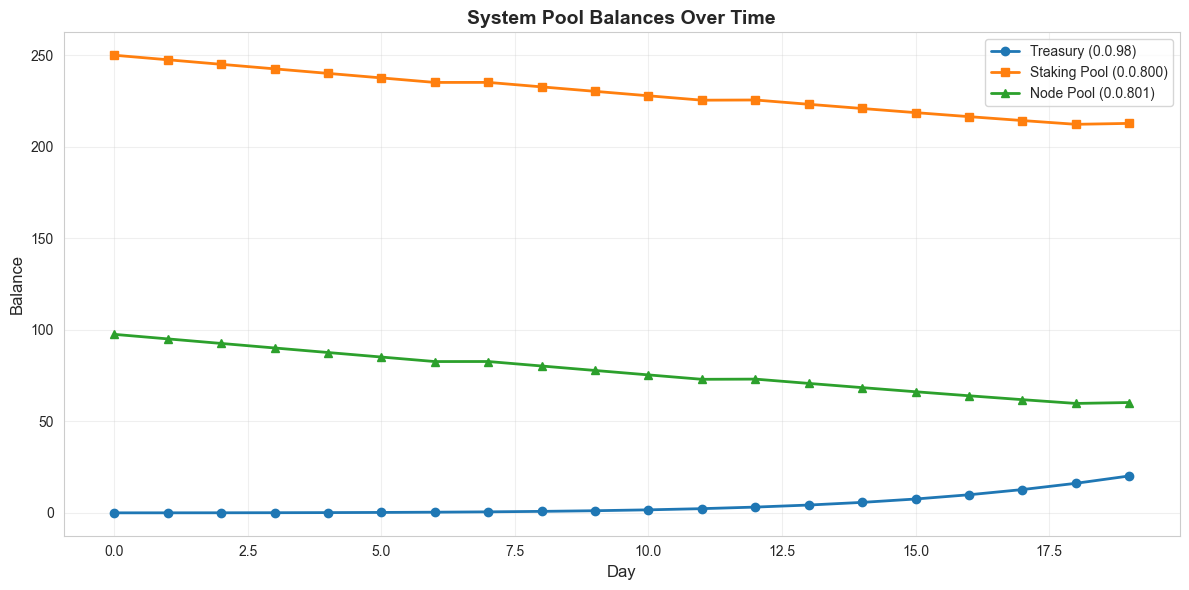

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))

days = [s.day for s in history]
ax.plot(days, [s.treasury_balance for s in history], label='Treasury (0.0.98)', linewidth=2, marker='o')
ax.plot(days, [s.staking_pool_balance for s in history], label='Staking Pool (0.0.800)', linewidth=2, marker='s')
ax.plot(days, [s.node_pool_balance for s in history], label='Node Pool (0.0.801)', linewidth=2, marker='^')

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Balance', fontsize=12)
ax.set_title('System Pool Balances Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Total Staker and Node Balances Over Time

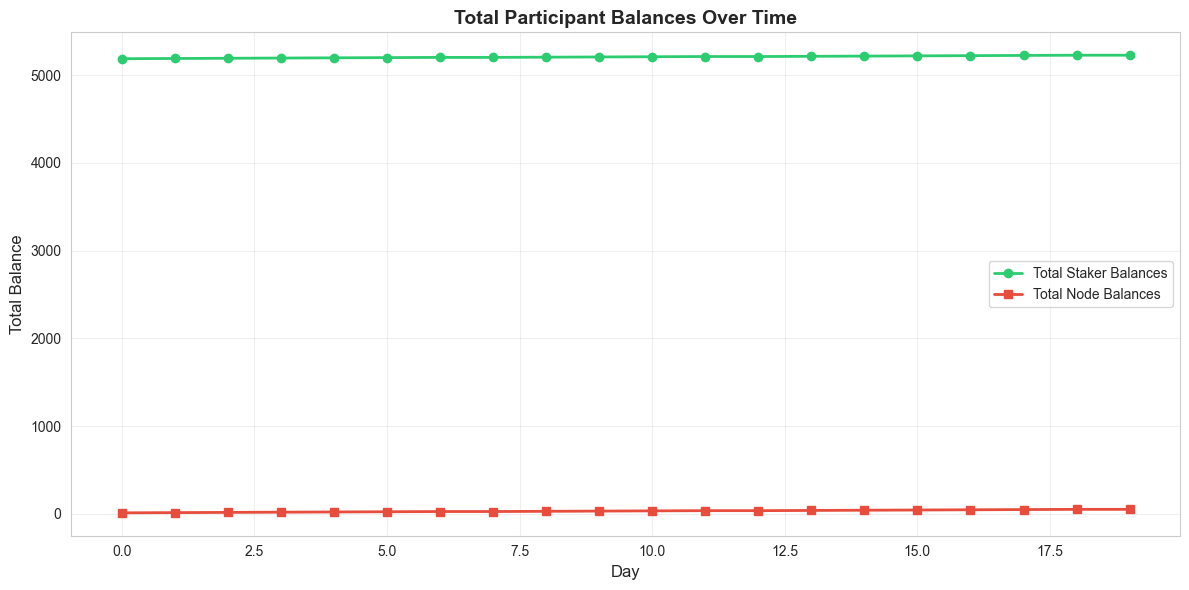

In [90]:
fig, ax = plt.subplots(figsize=(12, 6))

days = [s.day for s in history]
ax.plot(days, [s.total_staker_balance for s in history], label='Total Staker Balances', linewidth=2, marker='o', color='#2ecc71')
ax.plot(days, [s.total_node_balance for s in history], label='Total Node Balances', linewidth=2, marker='s', color='#e74c3c')

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Total Balance', fontsize=12)
ax.set_title('Total Participant Balances Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Rewards Distribution Over Time

This plot shows the **daily rewards** distributed to stakers and nodes. 

**Why staker rewards might be 0:**
- Stakers need to stake for at least 1 day before becoming eligible (`min_stake_age_days=1`)
- Their staked node must be eligible (pass performance threshold)
- The staking pool must have sufficient balance
- If no stakers meet all criteria, `rs` (staker rewards) will be 0

**Why rewards alternate:**
- The reward schedule and pool balances determine how much can be paid each day
- If the staking pool balance is insufficient, staker rewards may be 0 even if `rs_target` > 0
- Node rewards follow a similar pattern based on node pool balance

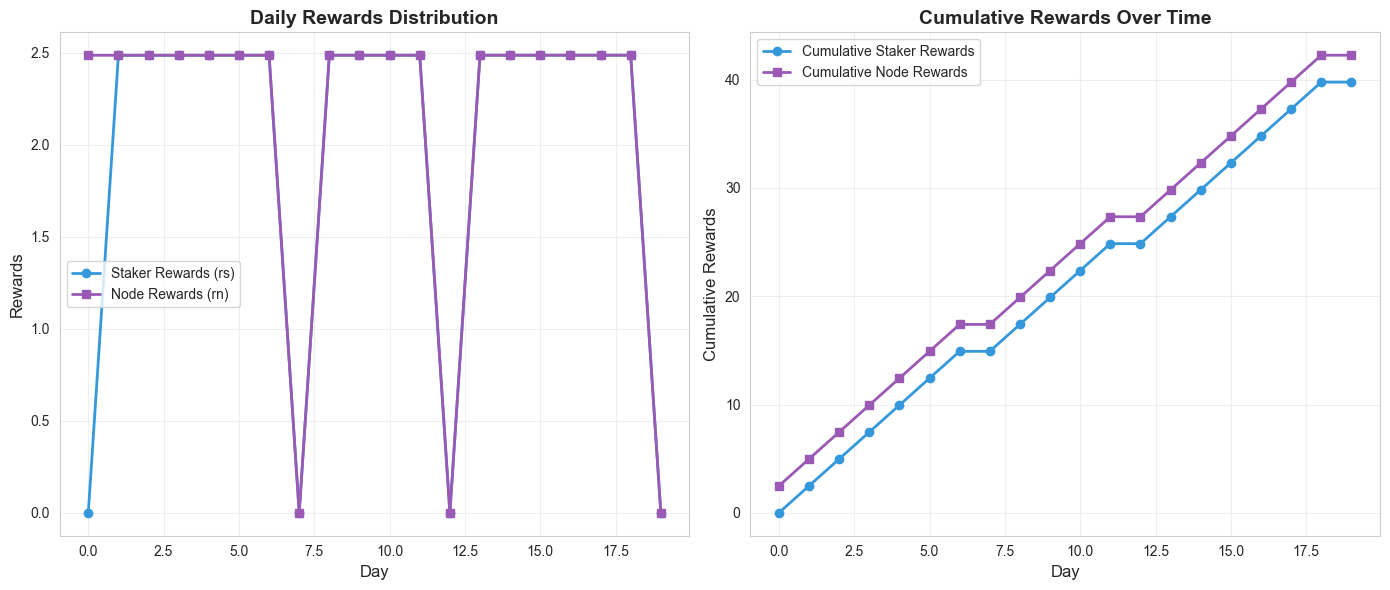

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

days = [s.day for s in history]
staker_rewards = [s.rs for s in history]
node_rewards = [s.rn for s in history]

# Daily rewards
ax1.plot(days, staker_rewards, label='Staker Rewards (rs)', linewidth=2, marker='o', color='#3498db')
ax1.plot(days, node_rewards, label='Node Rewards (rn)', linewidth=2, marker='s', color='#9b59b6')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Rewards', fontsize=12)
ax1.set_title('Daily Rewards Distribution', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Cumulative rewards
cumulative_staker = np.cumsum(staker_rewards)
cumulative_node = np.cumsum(node_rewards)
ax2.plot(days, cumulative_staker, label='Cumulative Staker Rewards', linewidth=2, marker='o', color='#3498db')
ax2.plot(days, cumulative_node, label='Cumulative Node Rewards', linewidth=2, marker='s', color='#9b59b6')
ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('Cumulative Rewards', fontsize=12)
ax2.set_title('Cumulative Rewards Over Time', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Fees and Net Flow

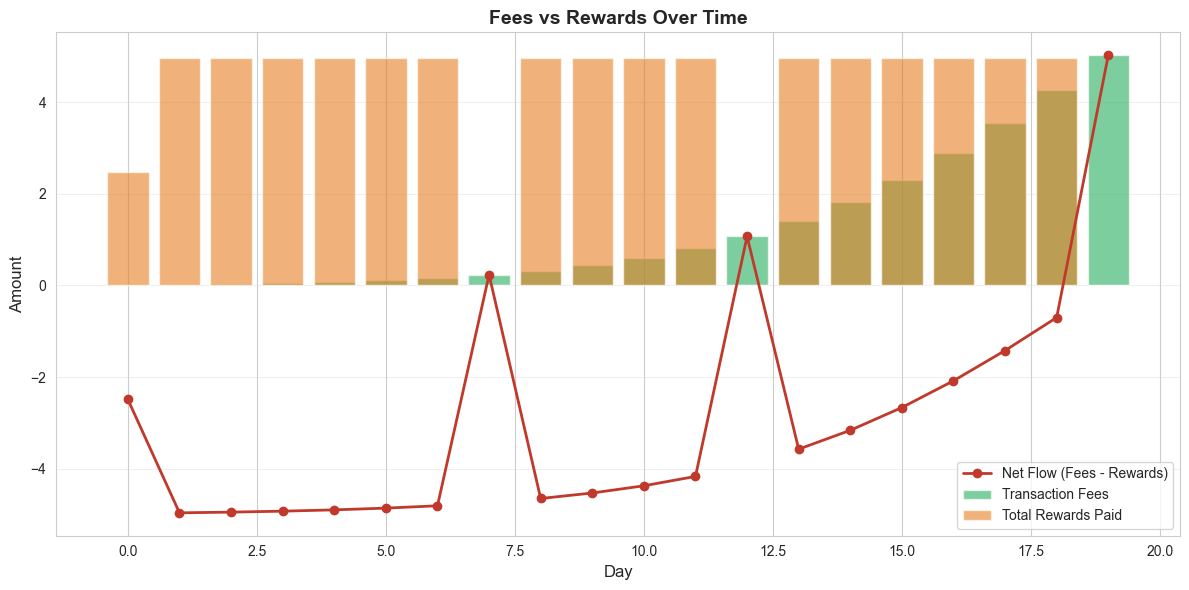

In [92]:
fig, ax = plt.subplots(figsize=(12, 6))

days = [s.day for s in history]
fees = [s.fees for s in history]
total_rewards = [s.rs + s.rn for s in history]
net_flow = [f - r for f, r in zip(fees, total_rewards)]

ax.bar(days, fees, alpha=0.6, label='Transaction Fees', color='#27ae60')
ax.bar(days, total_rewards, alpha=0.6, label='Total Rewards Paid', color='#e67e22')
ax.plot(days, net_flow, label='Net Flow (Fees - Rewards)', linewidth=2, marker='o', color='#c0392b')

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Amount', fontsize=12)
ax.set_title('Fees vs Rewards Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 5. Eligible Nodes Over Time

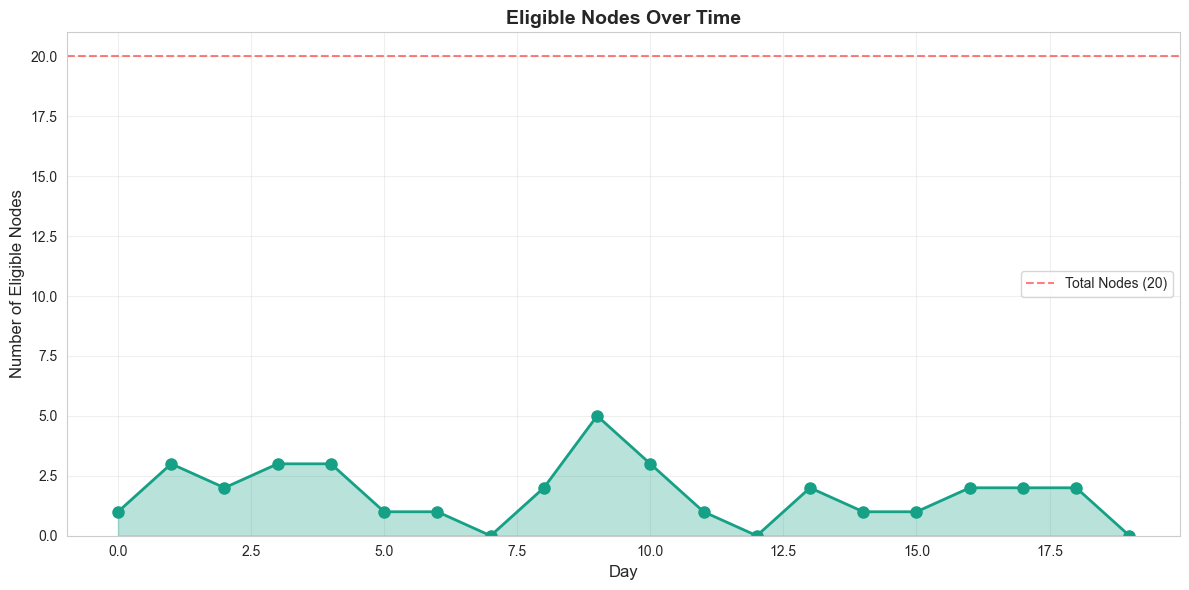

In [93]:
fig, ax = plt.subplots(figsize=(12, 6))

days = [s.day for s in history]
eligible = [s.eligible_nodes for s in history]
total_nodes = system.nodes.num_nodes

ax.plot(days, eligible, linewidth=2, marker='o', color='#16a085', markersize=8)
ax.axhline(y=total_nodes, color='r', linestyle='--', alpha=0.5, label=f'Total Nodes ({total_nodes})')
ax.fill_between(days, 0, eligible, alpha=0.3, color='#16a085')

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Number of Eligible Nodes', fontsize=12)
ax.set_title('Eligible Nodes Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, total_nodes + 1)
plt.tight_layout()
plt.show()

## 6. Top Stakers and Nodes (Final Rankings)

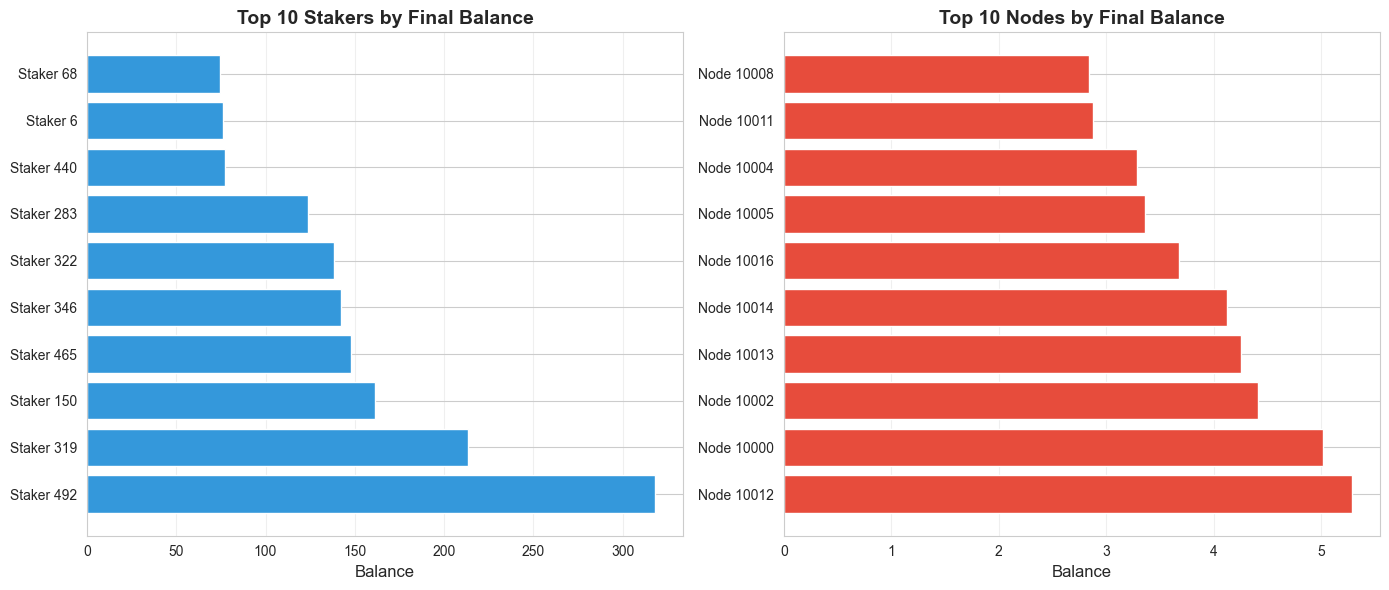

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

staker_balances = system.stakers.balance_stakers_account
node_balances = system.nodes.balance_nodes_account

# Top 10 stakers
top_stakers = sorted(staker_balances.items(), key=lambda kv: kv[1], reverse=True)[:10]
staker_ids = [f"Staker {sid}" for sid, _ in top_stakers]
staker_vals = [bal for _, bal in top_stakers]

ax1.barh(range(len(staker_ids)), staker_vals, color='#3498db')
ax1.set_yticks(range(len(staker_ids)))
ax1.set_yticklabels(staker_ids)
ax1.set_xlabel('Balance', fontsize=12)
ax1.set_title('Top 10 Stakers by Final Balance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Top 10 nodes
top_nodes = sorted(node_balances.items(), key=lambda kv: kv[1], reverse=True)[:10]
node_ids = [f"Node {nid}" for nid, _ in top_nodes]
node_vals = [bal for _, bal in top_nodes]

ax2.barh(range(len(node_ids)), node_vals, color='#e74c3c')
ax2.set_yticks(range(len(node_ids)))
ax2.set_yticklabels(node_ids)
ax2.set_xlabel('Balance', fontsize=12)
ax2.set_title('Top 10 Nodes by Final Balance', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 7. Rewards Distribution Histogram

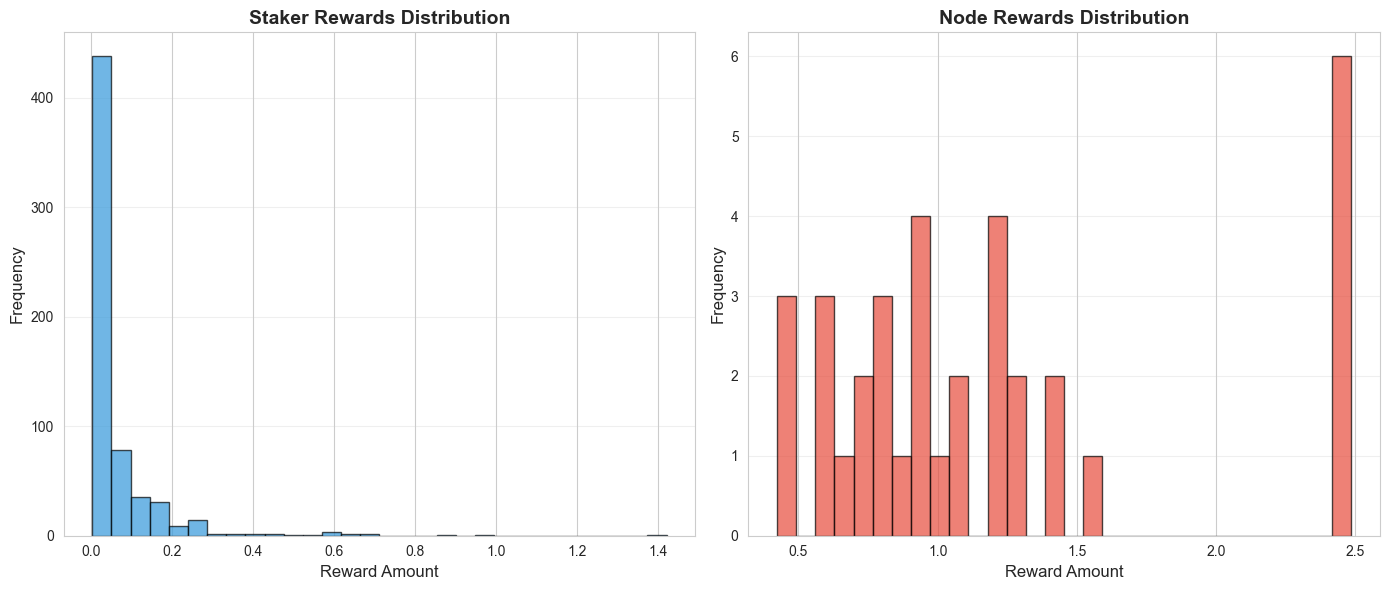

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Collect all rewards across all days
all_staker_rewards = []
all_node_rewards = []
for snapshot in history:
    all_staker_rewards.extend([r for r in snapshot.staker_rewards.values() if r > 0])
    all_node_rewards.extend([r for r in snapshot.node_rewards.values() if r > 0])

# Staker rewards distribution
if all_staker_rewards:
    ax1.hist(all_staker_rewards, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Reward Amount', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Staker Rewards Distribution', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')

# Node rewards distribution
if all_node_rewards:
    ax2.hist(all_node_rewards, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Reward Amount', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Node Rewards Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Balance Distribution (Final State)

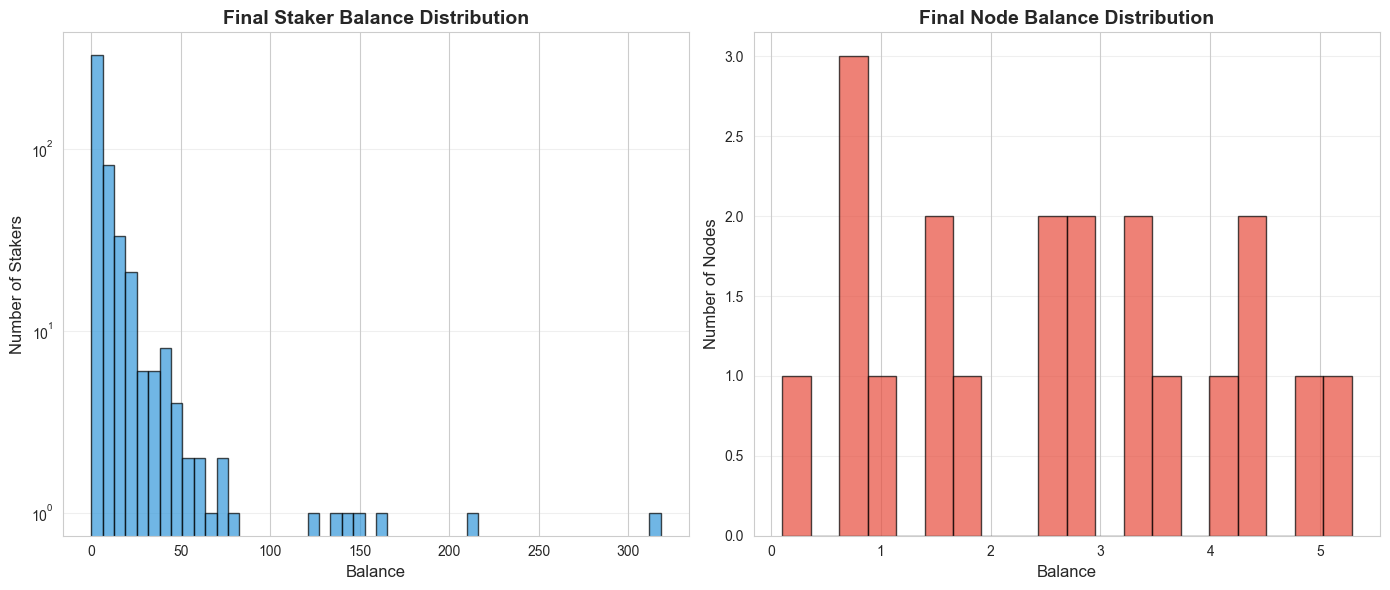

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

staker_balances = list(system.stakers.balance_stakers_account.values())
node_balances = list(system.nodes.balance_nodes_account.values())

# Staker balance distribution
ax1.hist(staker_balances, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Balance', fontsize=12)
ax1.set_ylabel('Number of Stakers', fontsize=12)
ax1.set_title('Final Staker Balance Distribution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_yscale('log')

# Node balance distribution
ax2.hist(node_balances, bins=20, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Balance', fontsize=12)
ax2.set_ylabel('Number of Nodes', fontsize=12)
ax2.set_title('Final Node Balance Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Summary Statistics Table

In [97]:
# Create summary DataFrame
summary_data = {
    'Day': [s.day for s in history],
    'Fees': [s.fees for s in history],
    'Staker Rewards': [s.rs for s in history],
    'Node Rewards': [s.rn for s in history],
    'Treasury Balance': [s.treasury_balance for s in history],
    'Staking Pool Balance': [s.staking_pool_balance for s in history],
    'Node Pool Balance': [s.node_pool_balance for s in history],
    'Total Staker Balance': [s.total_staker_balance for s in history],
    'Total Node Balance': [s.total_node_balance for s in history],
    'Eligible Nodes': [s.eligible_nodes for s in history],
}

df = pd.DataFrame(summary_data)

# Display summary statistics
print("=== Summary Statistics ===")
print(df.describe())
print("\n=== Final State ===")
print(df.iloc[-1])

# Display first few rows
print("\n=== First 5 Days ===")
print(df.head())

=== Summary Statistics ===
            Day       Fees  Staker Rewards  Node Rewards  Treasury Balance  \
count  20.00000  20.000000       20.000000     20.000000         20.000000   
mean    9.50000   1.259406        1.988207      2.112457          4.340675   
std     5.91608   1.553713        1.019929      0.910463          5.969112   
min     0.00000   0.000000        0.000000      0.000000          0.000000   
25%     4.75000   0.105540        2.485051      2.485051          0.200599   
50%     9.50000   0.523534        2.485216      2.485216          1.400826   
75%    14.25000   1.936561        2.485355      2.485355          6.175193   
max    19.00000   5.021503        2.485437      2.485437         20.150494   

       Staking Pool Balance  Node Pool Balance  Total Staker Balance  \
count             20.000000          20.000000             20.000000   
mean             229.666974          77.181974           5207.992466   
std               11.818836          11.818836        

## 10. Heatmap: Rewards Over Time (Top Participants)

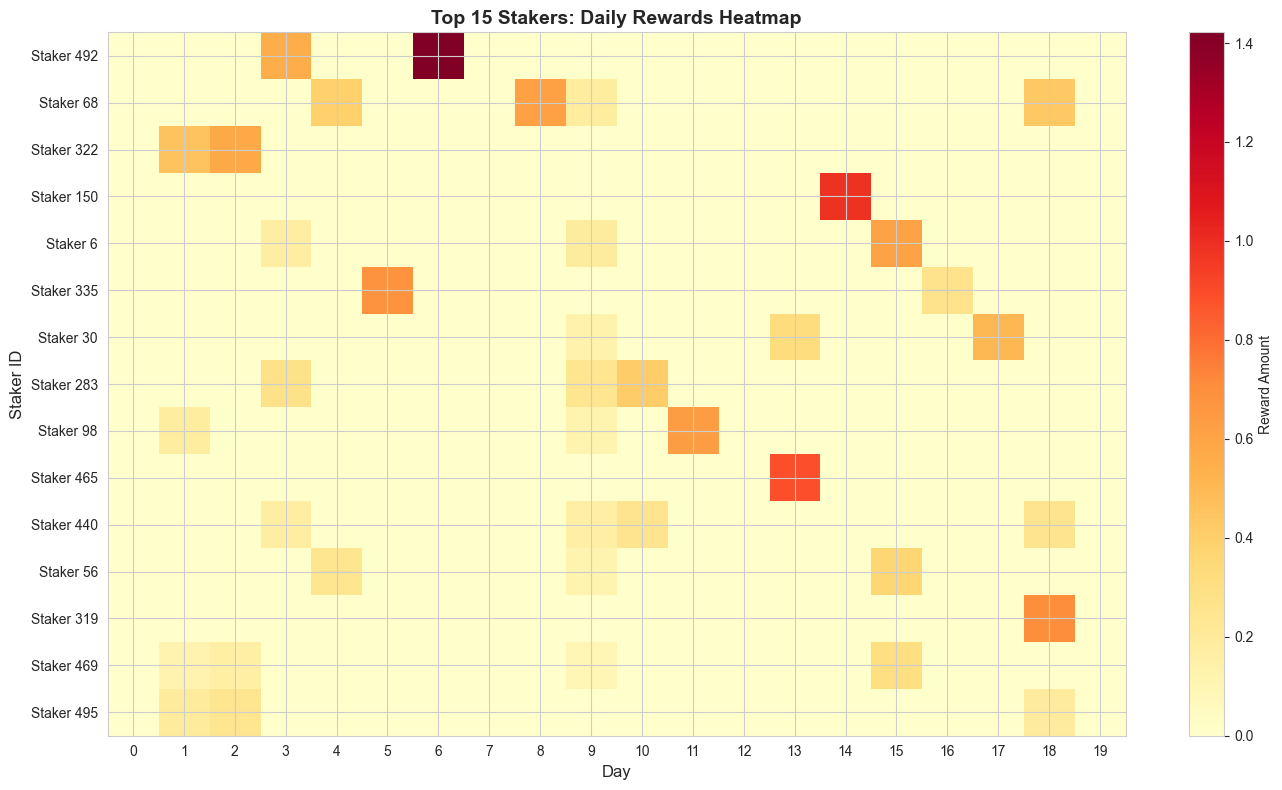

In [98]:
# Collect top stakers across all days
all_staker_ids = set()
for snapshot in history:
    all_staker_ids.update(snapshot.staker_rewards.keys())

# Get top 15 stakers by total rewards
total_rewards_per_staker = {}
for staker_id in all_staker_ids:
    total = sum(s.staker_rewards.get(staker_id, 0) for s in history)
    total_rewards_per_staker[staker_id] = total

top_staker_ids = sorted(total_rewards_per_staker.items(), key=lambda kv: kv[1], reverse=True)[:15]
top_staker_ids = [sid for sid, _ in top_staker_ids]

# Build heatmap data
heatmap_data = []
for staker_id in top_staker_ids:
    row = [s.staker_rewards.get(staker_id, 0) for s in history]
    heatmap_data.append(row)

if heatmap_data:
    fig, ax = plt.subplots(figsize=(14, 8))
    im = ax.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    
    ax.set_xticks(range(len(history)))
    ax.set_xticklabels([s.day for s in history])
    ax.set_yticks(range(len(top_staker_ids)))
    ax.set_yticklabels([f'Staker {sid}' for sid in top_staker_ids])
    
    ax.set_xlabel('Day', fontsize=12)
    ax.set_ylabel('Staker ID', fontsize=12)
    ax.set_title('Top 15 Stakers: Daily Rewards Heatmap', fontsize=14, fontweight='bold')
    
    plt.colorbar(im, ax=ax, label='Reward Amount')
    plt.tight_layout()
    plt.show()

## 11. Cumulative Rewards Comparison

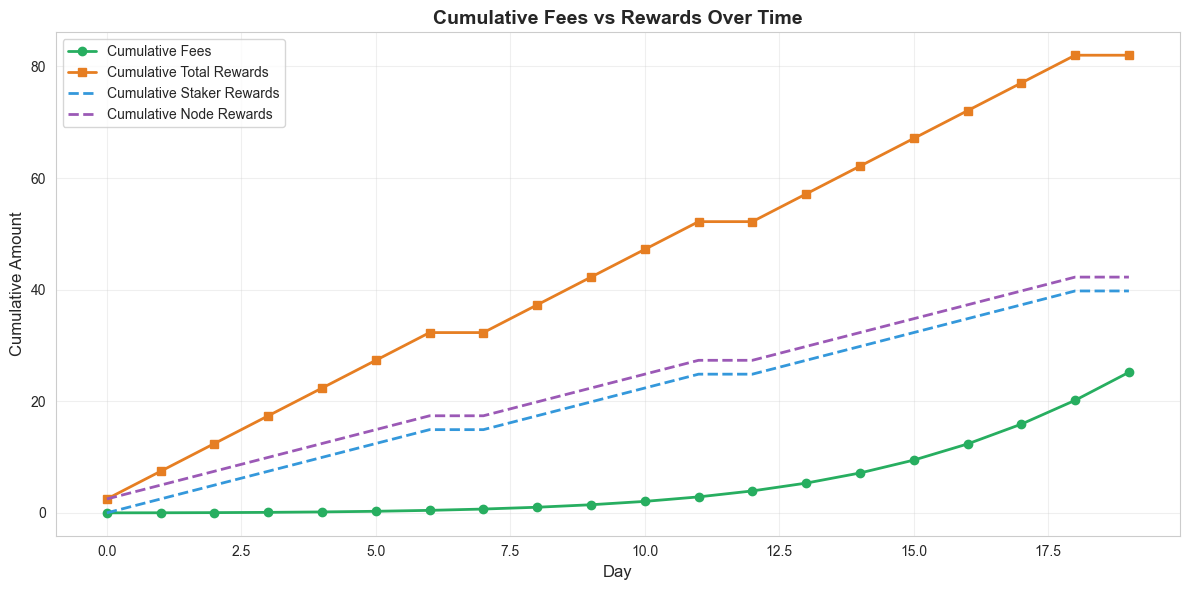

In [99]:
fig, ax = plt.subplots(figsize=(12, 6))

days = [s.day for s in history]
cumulative_fees = np.cumsum([s.fees for s in history])
cumulative_staker_rewards = np.cumsum([s.rs for s in history])
cumulative_node_rewards = np.cumsum([s.rn for s in history])
cumulative_total_rewards = cumulative_staker_rewards + cumulative_node_rewards

ax.plot(days, cumulative_fees, label='Cumulative Fees', linewidth=2, marker='o', color='#27ae60')
ax.plot(days, cumulative_total_rewards, label='Cumulative Total Rewards', linewidth=2, marker='s', color='#e67e22')
ax.plot(days, cumulative_staker_rewards, label='Cumulative Staker Rewards', linewidth=2, linestyle='--', color='#3498db')
ax.plot(days, cumulative_node_rewards, label='Cumulative Node Rewards', linewidth=2, linestyle='--', color='#9b59b6')

ax.set_xlabel('Day', fontsize=12)
ax.set_ylabel('Cumulative Amount', fontsize=12)
ax.set_title('Cumulative Fees vs Rewards Over Time', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()